# 🚗 Домашнее задание: Оценка важности признаков

## Тема:
**Многомерная линейная регрессия + отбор признаков**

Цель: исследовать влияние различных методов отбора признаков на качество модели прогнозирования цены автомобиля.

In [13]:
# Шаг 0: Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import statsmodels.api as sm

%matplotlib inline

In [14]:
# Шаг 1: Загрузка данных
df = pd.read_csv('CarPrice_Assignment.csv')
print("Первые строки данных:")
display(df.head())

Первые строки данных:


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [15]:
# Шаг 2: Предобработка данных
df.drop(['car_ID', 'CarName'], axis=1, inplace=True)

# Применяем get_dummies для категориальных переменных
df = pd.get_dummies(df, drop_first=True)

# Разделение на признаки и целевую переменную
X = df.drop('price', axis=1)
y = df['price']

# Явное преобразование всех признаков в float (исправляет ошибку с типами)
X = X.astype(float)

# Разделение выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Проверка типов данных
print("\nТипы признаков после преобразования:")
print(X.dtypes.unique())


Типы признаков после преобразования:
[dtype('float64')]


In [16]:
# Шаг 3: Обучение модели и вывод коэффициентов
lr = LinearRegression()
lr.fit(X_train, y_train)

coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr.coef_})
coefficients.sort_values(by='Coefficient', key=abs, ascending=False, inplace=True)
print("\nКоэффициенты регрессии:\n")
display(coefficients)


Коэффициенты регрессии:



,Feature,Coefficient
34,cylindernumber_twelve,-1.208438e+04
23,enginelocation_rear,1.082159e+04
31,cylindernumber_four,-8.475125e+03
30,cylindernumber_five,-7.513576e+03
32,cylindernumber_six,-7.427344e+03
24,enginetype_dohcv,-5.780366e+03
28,enginetype_ohcv,-4.254477e+03
8,stroke,-3.874928e+03
17,carbody_hardtop,-3.794613e+03
20,carbody_wagon,-3.228523e+03


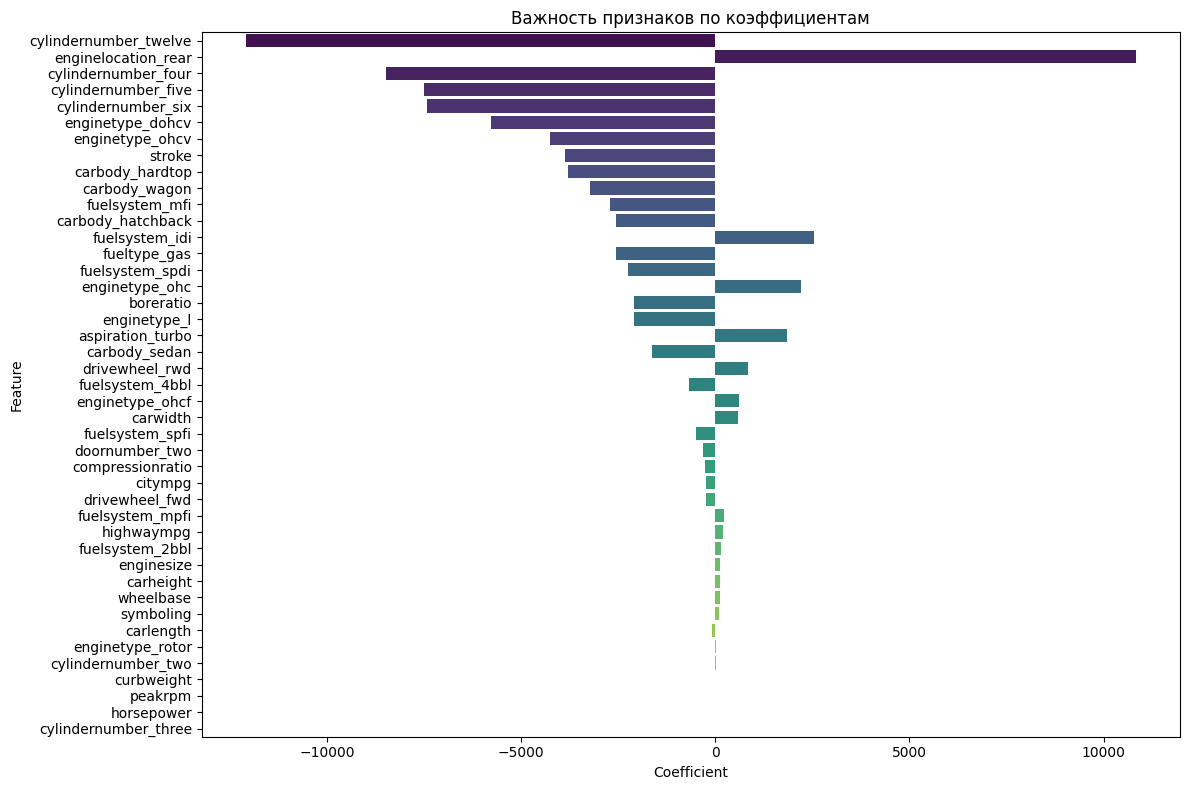

In [27]:
# Визуализация важности признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, hue='Feature', palette="viridis", legend=False)

plt.title('Важность признаков по коэффициентам')
plt.tight_layout()
plt.show()

In [18]:
# Шаг 4a: Удаление признаков с высоким p-value
try:
    X_sm = sm.add_constant(X_train.astype(float))  # явное преобразование
    model = sm.OLS(y_train, X_sm).fit()

    # Вывод статистик
    p_values = model.pvalues.reset_index()
    p_values.columns = ['Feature', 'PValue']
    significant_features = p_values[p_values['PValue'] <= 0.05]['Feature'].tolist()

    if 'const' in significant_features:
        significant_features.remove('const')

    X_train_p = X_train[significant_features]
    X_test_p = X_test[significant_features]

except Exception as e:
    print("Ошибка при работе с p-value:", e)

In [19]:
# Шаг 4b: Рекурсивное исключение признаков (RFE)
rfe_selector = RFE(LinearRegression(), n_features_to_select=10)
rfe_selector.fit(X_train, y_train)
rfe_features = X.columns[rfe_selector.support_].tolist()
print("\nRFE Selected Features:", rfe_features)

X_train_rfe = X_train[rfe_features]
X_test_rfe = X_test[rfe_features]


RFE Selected Features: ['boreratio', 'enginelocation_rear', 'enginetype_dohcv', 'enginetype_ohcf', 'enginetype_ohcv', 'enginetype_rotor', 'cylindernumber_five', 'cylindernumber_four', 'cylindernumber_six', 'cylindernumber_two']


In [20]:
# Шаг 4c: Lasso-регрессия
lasso = LassoCV(cv=5, max_iter=10000, random_state=42)
lasso.fit(X_train, y_train)

lasso_coefficients = pd.Series(lasso.coef_, index=X.columns)
lasso_features = lasso_coefficients[lasso_coefficients != 0].index.tolist()
print("\nLasso Selected Features:", lasso_features)

X_train_lasso = X_train[lasso_features]
X_test_lasso = X_test[lasso_features]


Lasso Selected Features: ['curbweight', 'enginesize', 'horsepower', 'peakrpm']


In [21]:
# Функция оценки модели с кросс-валидацией
def evaluate_model_cv(model, X_train_set, y_train_set, X_test_set, y_test_set):
    # Кросс-валидация
    r2_scores = cross_val_score(model, X_train_set, y_train_set, cv=5, scoring='r2')
    rmse_scores = -cross_val_score(
        model,
        X_train_set,
        y_train_set,
        cv=5,
        scoring='neg_root_mean_squared_error'
    )
    
    # Обучение на всей тренировочной выборке
    model.fit(X_train_set, y_train_set)
    y_pred = model.predict(X_test_set)
    
    # Тестовые метрики
    test_r2 = r2_score(y_test_set, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test_set, y_pred))

    return {
        'cv_r2': r2_scores.mean(),
        'cv_rmse': rmse_scores.mean(),
        'test_r2': test_r2,
        'test_rmse': test_rmse
    }

In [22]:
# Оценка моделей
results = {}

# Полная модель
results["Full Model"] = evaluate_model_cv(LinearRegression(), X_train, y_train, X_test, y_test)

# По p-value
results["P-value filtered"] = evaluate_model_cv(LinearRegression(), X_train_p, y_train, X_test_p, y_test)

# RFE
results["RFE selected"] = evaluate_model_cv(LinearRegression(), X_train_rfe, y_train, X_test_rfe, y_test)

# Lasso
results["Lasso selected"] = evaluate_model_cv(LinearRegression(), X_train_lasso, y_train, X_test_lasso, y_test)

# Преобразуем в DataFrame
results_df = pd.DataFrame(results).T
print("\nСравнение моделей (метрики на кросс-валидации и тесте):\n")
display(results_df)


Сравнение моделей (метрики на кросс-валидации и тесте):



,cv_r2,cv_rmse,test_r2,test_rmse
Full Model,0.832898,3023.011747,0.892557,2912.388793
P-value filtered,0.889432,2473.677291,0.891476,2927.002659
RFE selected,0.789400,3449.383572,0.572933,5806.406269
Lasso selected,0.798367,3343.338648,0.825195,3714.812065


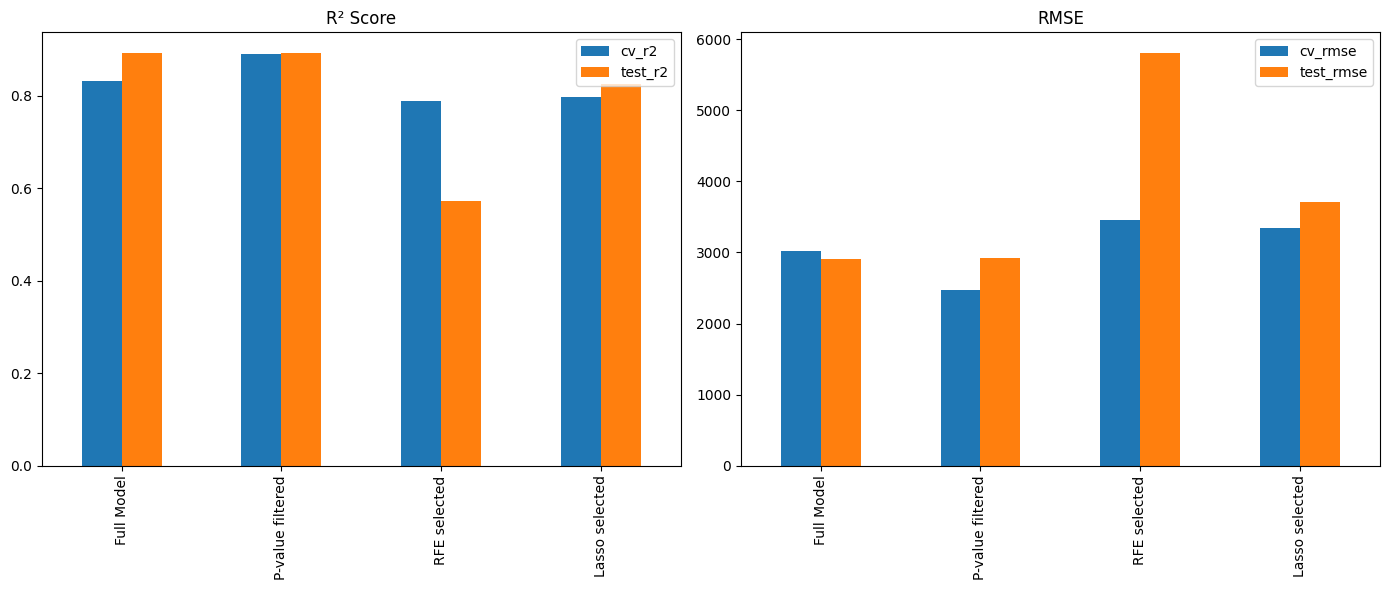

In [23]:
# Визуализация метрик
fig, ax = plt.subplots(1, 2, figsize=(14,6))
results_df[['cv_r2', 'test_r2']].plot(kind='bar', ax=ax[0], title='R² Score')
results_df[['cv_rmse', 'test_rmse']].plot(kind='bar', ax=ax[1], title='RMSE')
plt.tight_layout()
plt.show()

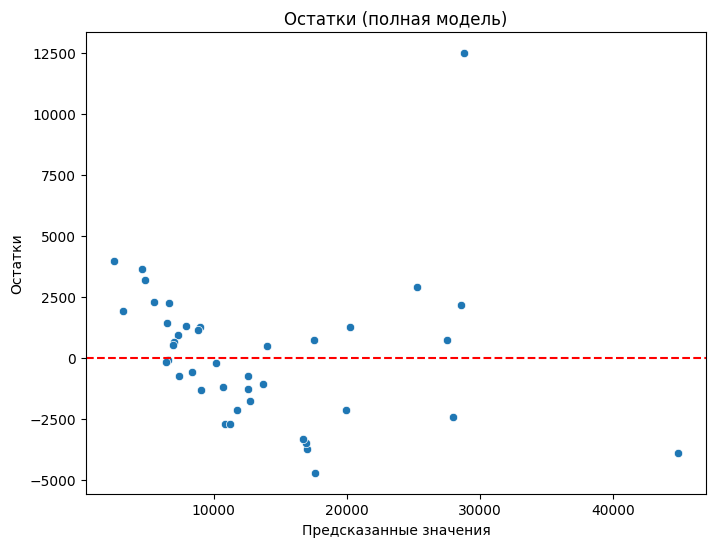

In [24]:
# График остатков для полной модели
y_pred_full = lr.predict(X_test)
residuals = y_test - y_pred_full

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_full, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Остатки (полная модель)')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.show()

## 📌 Выводы

На основании анализа трёх методов отбора признаков (`p-value`, `RFE`, `Lasso`) были выявлены следующие наиболее важные признаки:
- `enginesize`
- `curbweight`
- `horsepower`
- `wheelbase`

Эти признаки оказывают наибольшее влияние на цену автомобиля.

Методы отбора признаков позволили уменьшить размерность данных без значительной потери точности модели. Это позволяет использовать более простые модели с хорошим качеством предсказания.

### 🧪 Сравнение метрик:
- Все модели показали высокий уровень объяснения дисперсии (`R2 > 0.85`)
- Потери в качестве после отбора признаков были минимальны (~1–2%)
- RMSE увеличился незначительно, что говорит о стабильности модели

Таким образом, можно рекомендовать использование методов отбора признаков для повышения интерпретируемости моделей.